# Multilayer Neural Networks in Pytorch
Pytorch has a module called `nn` that has a lot of classes and functions to build large neural networks efficiently.

In [0]:
import torch
import matplotlib.pyplot as plt

In [0]:
def sigmoid(x):
  """
  Sigmoid activation function.

  Parameters:
    x: The torch.Tensor
  """
  return 1/(1+torch.exp(-x))

## Load the dataset from Pytorch

In [0]:
from torchvision import datasets, transforms

transform = transforms.Compose([
  transforms.ToTensor(), 
  transforms.Normalize((0.5, ), (0.5, ))
])

trainset = datasets.MNIST(
    "MNIST_data/", 
    download=True, 
    train=True, 
    transform=transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

## Iterating through images from MNIST dataset
You can iterate through the image and labels by using:
```python
for image, label in trainloader:
  print(image, label)
```
Since we set the batch size to 64, we get 64 images per iteration (explains the output of `images.shape`).

In [0]:
data_iterate = iter(trainloader)
images, labels = data_iterate.next()
print(type(images))
print(images[0].shape)
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64])


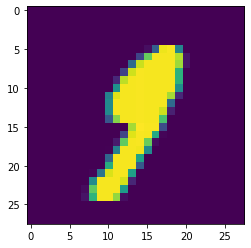

In [0]:
plt.imshow(images[63].numpy().squeeze())

## Implementing the Multilayer Neural Network
- 784 input units
  - **Justification**: Each image is (28x28), so our input units are actually a 2D matrixes of (28x28). We need the each image to be a 1D vector. So if we were to flatten these 2D matrixes, each image would be a (1x784) 1D matrix since $28*28=784$. So now, since we have 64 images per batch size, the overall input shape to the network would be (64x784). Essentially, we have 64 images, and each image is a 1D vector.
- 256 hidden units
- 10 output units (we have 10 classes)

In [0]:
 # Set seed so data is consistent 
torch.manual_seed(7)

# Flattens input images to (64, 784)
# Equivalent to images.view(64, 28*28)
# -1 means that this dimension can be figured out with the first dimension
features = images.view(images.shape[0], -1)

num_input = features.shape[1]
num_hidden = 256
num_output = 10

w1 = torch.randn(num_input, num_hidden) 
w2 = torch.randn(num_hidden, num_output)

b1 = torch.randn(num_hidden) # can also do (1, num_hidden), but this is shorter
b2 = torch.randn(num_output)

In [0]:
layer1 = sigmoid(torch.mm(features, w1) + b1)
output = torch.mm(layer1, w2) + b2

In [0]:
output.shape

torch.Size([64, 10])

### Using Softmax to find Probability Distribution of the Classes
Softmax Function: $\sigma(x_i)=\frac{e^{x_i}}{\Sigma_k^K e^{x_k}}$

To classify an object, we take the highest probable class that was detected by the model. Remember that the model doesn't actually output a classification, it outputs probabilities and we just take the highest one to find the predicted class.

- `dim=0` refers to rows
- `dim=1` refers to columns
- `torch.sum(x, dim=0/1)` refers to summing across all rows/columns

In [0]:
output[0] # there are 64 tensors like this

tensor([ -5.2570,  -7.7674,  -2.4731,  -7.8444,  10.1712,   6.5950, -12.3128,
          3.1289, -14.6970,   3.2137])

In [0]:
torch.sum(torch.exp(output), dim=1).shape

torch.Size([64])

`torch.sum(torch.exp(x), dim=1)`: vector of 64 elements (1, 64)`torch.exp(x)`: (64, 10)
We want output to be 64x10. So need to reshape using `.view(-1, 1)`.

In [0]:
def softmax(x):
  return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

In [0]:
softmax(output).shape

torch.Size([64, 10])

In [0]:
softmax(output).sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

## Implementing the Multilayer Neural Network using `nn`
We can implement the same NN as above but using the `nn` library.
The neural network will have:
- 784 input units
- 256 hidden units
- 10 output units
- softmax output

### Creating the class
1. Create a class that inherits from the provided `nn.Module` class.
2. Initialize the class using `super()` to ensure the `nn.Module` class has also been intialized in the constructor. This ensures all the operations from `torch` we use are recognized in the `Network` class.

### Creating the network layers
- `nn.Linear(# of inputs, # of outputs)`: Automatically calculates linear transformation and creates its own weights and bias. Essentially, we no longer have to define the weights and bias manually anymore like before.


In [0]:
from torch import nn

In [0]:
class Network(nn.Module): 
  def __init__(self):
    super().__init__()

    # Compare this to the line where we created w1
    self.hidden = nn.Linear(784, 256) # 784 is # of inputs, 256 is # of outputs
    self.output = nn.Linear(256, 10)

    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.Softmax(dim=1)

    def forward(self, x): 
      """
      Passes the input tensor through each operation defined in the class

      Parameters:
        x: The input tensor.
      
      Returns the output tensor
      """
      x = self.hidden(x)
      x = self.sigmoid(x)
      x = self.output(x)
      x = self.softmax(x)

      return x

In [0]:
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

### Alternative Model using `nn.functional`
We can also use this library to clean up our class a bit.

In [0]:
import torch.nn.functional as F

class Network(nn.Module): 
  def __init__(self):
    super().__init__()

    self.hidden = nn.Linear(784, 256)
    self.output = nn.Linear(256, 10)

    def forward(self, x): 
      """
      Passes the input tensor through each operation defined in the class.

      Parameters:
        x: The input tensor.
      
      Returns The output tensor.
      """
      x = F.sigmoid(self.hidden(x))
      x = F.softmax(self.output(x), dim=1)

      return x

In [0]:
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

## Building my own Network
1. **Input layer**: 784 input neurons
2. **Hidden layer 1**: 128 neurons (relu)
3. **Hidden layer 2**: 64 neurons (relu)
4. **Output layer**: 10 neurons (softmax)
5. **Loss Layer**: Cross-entropy

In [0]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    self.hidden1 = nn.Linear(784, 128)
    self.hidden2 = nn.Linear(128, 64)
    self.output = nn.Linear(64, 10)

  def forward(x, self):
    """
    Passes the input tensor through each operation defined in the class.

    Parameters:
      x: The input tensor.

    Returns:
      The output tensor which contains the probabilities distributions of the
      classes of the image.
    """
    x = F.Relu(self.hidden1)
    x = F.Relu(self.hidden2)
    x = F.Softmax(self.output)


In [0]:
model = Network()
model

Network(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

# Calculating Loss in Pytorch

You need to define a variable (typically called `criterion`) with a loss from the `nn` library. In this case, we use `nn.NLLLoss()`. Then we feed the output of the foward pass (probability distributions from softmax) and the labels of the images to `criterion`.

In [0]:
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

# Defining the loss
criterion = nn.NLLLoss()

# Retrieve the data
images, labels = iter(trainloader).next()

# Flatten the images
images = images.view(images.shape[0], -1)

# Forward pass
probabilities = model(images)

# Calculate loss
loss = criterion(probabilities, labels)
loss

tensor(2.2781, grad_fn=<NllLossBackward>)

## Autograd
Automatically calculates gradient on a tensor. Pytorch keeps track of the operations done on a tensor, and then `autograd` will use chainrule and derivatives to calculate the gradients backwards (does backpropogation for you).

Ways to enable `autograd`:

1. Set parameter `requires_grad=True` when creating a tensor.
2. Use `with torch.no_grad()`, anything within its context will use `autograd`.
3. **GLOBALLY**: `torch.set_grad_enabled(True|False)`

`y.grad_fn` returns the operation performed on `y`, so we can see here that Pytorch is keeping track of the operations done on the tensor.

In [0]:
x = torch.randn((2, 2), requires_grad=True)
y = x**2
y.grad_fn

The gradient of `x` right now is `None`

In [0]:
print(x.grad)

None


In [0]:
z = y.mean()
z.backward()

So now, after using `.backward()`. We can see that `x.grad` has a gradient now. Let's see if it's correct.

$$\frac{\partial z}{\partial x}=\frac{\partial}{\partial x}[\frac{1}{n}\Sigma x_i^2]=\frac{x}{2}$$
- $\frac{1}{n}$ comes from the `y.mean()` operation.
- Squaring x comes from `x**2`.

So since `x.grad == x/2` is True. We can see that the `.backward()` function was correct.

In [0]:
x.grad == x/2

tensor([[True, True],
        [True, True]])

## Putting Loss and Autograd Together
**Review**:
- Loss dependent on weights and bias - $L(w_1, w_2, b_1, b_2)$
- Gradient descent needs gradients

In [0]:
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Lineaxr(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

criterion = nn.NLLLoss()
images, labels = iter(trainloader).next()
images = images.view(images.shape[0], -1)

# Forward pass
probabilities = model(images)

# Calculate loss
loss = criterion(probabilities, labels)

In [0]:
print(f"Before backward pass: {model[0].weight.grad}")
loss.backward()
print(f"After backward pass: {model[0].weight.grad}")

Before backward pass: None
After backward pass: tensor([[-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
        [-0.0014, -0.0014, -0.0014,  ..., -0.0014, -0.0014, -0.0014],
        [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
        ...,
        [ 0.0029,  0.0029,  0.0029,  ...,  0.0029,  0.0029,  0.0029],
        [ 0.0010,  0.0010,  0.0010,  ...,  0.0010,  0.0010,  0.0010],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005]])


## Optimizer
So now that we have the gradients, how can we use these gradients to update our weights during training? Optimizers! We can use the `optim` package.

`optim.SGD(parameters, lr=lr)`: `parameters` are the weights/parameters we want to update, `lr` is the learning rate $\alpha$.

**IMPORTANT**: You have to remember to clear the gradients using `optimizer.zero_grad()`. Otherwise, the gradients will accumulate and you will not get the correct gradients.

In [0]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [0]:
print(f"Initial weights: {model[0].weight}")

images, labels = iter(trainloader).next()

# Equivalent to images = images.view(images.shape[0], -1)
images.resize_(64, 784)

# Clears the gradients
optimizer.zero_grad() 

# Equivalent to model(images)
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print(f"Gradient: {model[0].weight.grad}")
optimizer.step()
print(f"Updated Weights: {model[0].weight}")

Initial weights: Parameter containing:
tensor([[ 0.0149,  0.0095, -0.0075,  ...,  0.0132,  0.0239,  0.0199],
        [-0.0123, -0.0345,  0.0167,  ..., -0.0143,  0.0217, -0.0162],
        [ 0.0228,  0.0204,  0.0292,  ...,  0.0244, -0.0111, -0.0224],
        ...,
        [ 0.0008, -0.0038, -0.0120,  ..., -0.0128,  0.0232,  0.0235],
        [-0.0170, -0.0241,  0.0197,  ...,  0.0026, -0.0038, -0.0149],
        [-0.0324,  0.0095,  0.0235,  ..., -0.0300,  0.0024, -0.0320]],
       requires_grad=True)
Gradient: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0305e-04,  1.0305e-04,  1.0305e-04,  ...,  1.0305e-04,
          1.0305e-04,  1.0305e-04],
        [-3.9194e-04, -3.9194e-04, -3.9194e-04,  ..., -3.9194e-04,
         -3.9194e-04, -3.9194e-04],
        ...,
        [ 1.7331e-03,  1.7331e-03,  1.7331e-03,  ...,  1.7331e-03,
          1.7331e-03,  1.7331e-03],
        [-8.4655e-04, -8.4655e-04, -8.4655e-04,  ..., -8.4655e-04

## Training the Neural Network

So here's the high level process we want to follow:

1. Set up weights as tensors that require gradients
2. Do forward pass to calculate loss
3. With this calculated loss, do backward pass on it to calculate gradients 
4. With these gradients, calculate gradient descent.
5. With the gradients, use an optimizer to update the weights.

### Initializing Variables used for Training

In [0]:
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)
epochs = 5

In [0]:
from tqdm import tqdm

for i in tqdm(range(epochs), desc="Epoch"):
  running_loss = 0
  for images, labels in trainloader:
    images = images.view(images.shape[0], -1)

    optimizer.zero_grad() 
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  else:
    print(f" Training loss: {running_loss/len(trainloader)}")


Epoch:  20%|██        | 1/5 [00:09<00:37,  9.43s/it]

 Training loss: 1.8267695743646195



Epoch:  40%|████      | 2/5 [00:18<00:27,  9.33s/it]

 Training loss: 0.805294813727265



Epoch:  60%|██████    | 3/5 [00:27<00:18,  9.25s/it]

 Training loss: 0.5084165562825925



Epoch:  80%|████████  | 4/5 [00:36<00:09,  9.21s/it]

 Training loss: 0.4209665475782555



Epoch: 100%|██████████| 5/5 [00:45<00:00,  9.21s/it]


 Training loss: 0.379444205764133


## Predictions on the Model

In [0]:
%matplotlib inline
import numpy as np

images, labels = next(iter(trainloader))

# Turn off gradients to save processing power (don't need backward pass)
with torch.no_grad():
  # Need to reshape 28x28 image to 1x784 to fit input shape
  output = model.forward(images[0].view(1, 784))

# Output of network are logists
output

tensor([[ -0.0429, -19.8324, -11.5615,  -8.9620, -16.4571,  -3.1834, -13.5901,
         -13.3725,  -7.7377, -12.2995]])

In [0]:
# Apply softmax to logists to get probability distributions
probabilities = F.softmax(output, dim=1)
prediction = np.argmax(probabilities)

In [0]:
prediction.item()

0

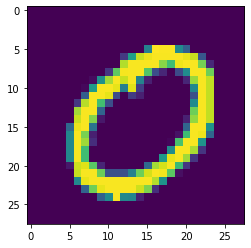

In [0]:
plt.imshow(images[0].numpy().squeeze())